In [685]:
import os
import sys
import importlib
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn


import requests
from bs4 import BeautifulSoup
from selenium import webdriver

import redfin

importlib.reload(redfin)

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.1f' % x)



In [575]:
!pwd
!ls


/Users/timcodes/ds/metis/metisgh/02_Luther/Luther
LICENSE                        geckodriver.log
README.md                      pickles
__pycache__                    redfin.py
explore_luther.ipynb           redfin_2018-04-18-08-51-54.csv


In [686]:
all_home_stats = redfin.load_all_home_stats()

df = redfin.clean_home_stats_df(all_home_stats)
df.head()

,Baths,Beds,County,Last Sold,Sales Price,Stories,Style,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Zip Code,rURL,Lot Size Sq. Ft.
0,nan,nan,Kings County,2017-08-02,1550000.0,3.0,Multi-Family (2-4 Unit),3360.0,nan,1899.0,1899.0,11211,/NY/Unknown/645-Bedford-Ave-11211/home/40736142,1627.0
2,1.0,2.0,Los Angeles County,2017-06-02,475000.0,1.0,Single Family Residential,864.0,nan,1926.0,1926.0,90301,/CA/Inglewood/110-E-Hardy-St-90301/home/6459725,3431.0
3,2.0,1.0,Los Angeles County,2015-08-20,555500.0,nan,Condo/Co-op,1072.0,nan,1972.0,1976.0,90049,/CA/Los-Angeles/530-S-Barrington-Ave-90049/uni...,nan
4,2.0,2.0,Los Angeles County,2018-04-11,294000.0,nan,Condo/Co-op,1142.0,nan,1970.0,1970.0,90301,/CA/Inglewood/526-E-Queen-St-90301/unit-3/home...,nan
5,2.0,5.0,Los Angeles County,2016-05-19,350000.0,nan,Multi-Family (2-4 Unit),1534.0,nan,1955.0,nan,90301,/CA/Inglewood/710-S-Ash-Ave-90301/home/6453009,5806.0


## Investigate DataFrame:
- Do overall stats using describe
- Groupby zipcodes and do stats

In [687]:
df.describe()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Lot Size Sq. Ft.
count,3440.0,3300.0,4340.0,2760.0,3998.0,474.0,3869.0,2937.0,2539.0
mean,2.6,3.2,1402975.2,3.1,2185.6,509.2,1957.6,1968.5,18364.5
std,2.8,3.0,3120452.5,4.2,3218.7,595.4,31.5,26.9,54154.3
min,1.0,1.0,210.0,1.0,153.0,0.0,1870.0,1899.0,1.0
25%,1.5,2.0,540000.0,1.0,1140.2,0.0,1930.0,1953.0,4718.5
50%,2.0,3.0,950000.0,2.0,1670.0,521.0,1960.0,1971.0,7196.0
75%,3.0,4.0,1575000.0,3.0,2410.8,801.0,1980.0,1987.0,12196.8
max,59.0,59.0,172500000.0,31.0,141498.0,10000.0,2016.0,2018.0,702622.8


In [688]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4340 entries, 0 to 4892
Data columns (total 14 columns):
Baths                 3440 non-null float64
Beds                  3300 non-null float64
County                4340 non-null object
Last Sold             4340 non-null datetime64[ns]
Sales Price           4340 non-null float64
Stories               2760 non-null float64
Style                 4340 non-null object
Total Sq. Ft.         3998 non-null float64
Unfinished Sq. Ft.    474 non-null float64
Year Built            3869 non-null float64
Year Renovated        2937 non-null float64
Zip Code              4340 non-null object
rURL                  4340 non-null object
Lot Size Sq. Ft.      2539 non-null float64
dtypes: datetime64[ns](1), float64(9), object(4)
memory usage: 508.6+ KB


In [689]:
group = df.groupby(['Style']).agg(['mean','std','sem'])
group

Baths         Beds          Sales Price             \
                           mean std sem mean  std sem        mean        std   
Style                                                                          
Condo/Co-op                 1.9 0.8 0.0  1.9  0.7 0.0   1135901.4  1116199.2   
Multi-Family (2-4 Unit)     4.3 5.2 0.4  6.0  5.8 0.4   1632218.3  1547841.8   
Multi-Family (5+ Unit)     11.5 9.5 1.0 14.0 10.1 1.1   4841726.0 14242083.0   
Single Family Residential   2.2 1.2 0.0  3.2  1.0 0.0   1349915.3  1745991.0   
Townhouse                   2.6 0.6 0.0  2.4  0.6 0.0   1135429.3   744639.1   

                                    Stories         Total Sq. Ft.          \
                                sem    mean std sem          mean     std   
Style                                                                       
Condo/Co-op                 27792.3     7.4 6.5 0.2        1228.2   574.3   
Multi-Family (2-4 Unit)     88053.6     2.2 0.8 0.1        3245.0  3092.0   
Multi-Family (5+ Unit)    1143951.6     3.6 1.9 0.2        8917.3 13389.0   
Single Family Residential   38886.3     1.4 0.6 0.0        2228.1  1264.5   
Townhouse                   47380.3     2.3 0.9 0.2        1679.6   529.3   

                                 Unfinished Sq. Ft.             Year Built  \
                             sem               mean   std   sem       mean   
Style                                                                        
Condo/Co-op                 15.7               72.6 234.2  38.5     1973.7   
Multi-Family (2-4 Unit)    179.4              243.0 486.0 243.0     1929.6   
Multi-Family (5+ Unit)    1096.9            10000.0   nan   nan     1938.6   
Single Family Residential   28.4              540.8 391.4  19.1     1950.2   
Townhouse                   34.8                0.0   0.0   0.0     1982.2   

                                   Year Renovated          Lot Size Sq. Ft.  \
                           std sem           mean  std sem             mean   
Style                                                                         
Condo/Co-op               30.4 0.9         1981.7 16.9 0.6          14610.0   
Multi-Family (2-4 Unit)   26.3 1.5         1936.0 30.0 2.1           5718.6   
Multi-Family (5+ Unit)    31.6 2.6         1964.0 21.2 2.3           6808.0   
Single Family Residential 26.7 0.6         1963.6 26.9 0.7          15918.6   
Townhouse                 20.0 1.3         1984.1 17.0 1.1          65077.5   

                                            
                               std     sem  
Style                                       
Condo/Co-op                16300.2 11526.0  
Multi-Family (2-4 Unit)     5591.9   326.1  
Multi-Family (5+ Unit)      5587.8   457.8  
Single Family Residential  41655.7   961.0  
Townhouse                 130116.2  8873.8

In [690]:
df.groupby(['Style']).agg(['mean','std','sem'])



Baths         Beds          Sales Price             \
                           mean std sem mean  std sem        mean        std   
Style                                                                          
Condo/Co-op                 1.9 0.8 0.0  1.9  0.7 0.0   1135901.4  1116199.2   
Multi-Family (2-4 Unit)     4.3 5.2 0.4  6.0  5.8 0.4   1632218.3  1547841.8   
Multi-Family (5+ Unit)     11.5 9.5 1.0 14.0 10.1 1.1   4841726.0 14242083.0   
Single Family Residential   2.2 1.2 0.0  3.2  1.0 0.0   1349915.3  1745991.0   
Townhouse                   2.6 0.6 0.0  2.4  0.6 0.0   1135429.3   744639.1   

                                    Stories         Total Sq. Ft.          \
                                sem    mean std sem          mean     std   
Style                                                                       
Condo/Co-op                 27792.3     7.4 6.5 0.2        1228.2   574.3   
Multi-Family (2-4 Unit)     88053.6     2.2 0.8 0.1        3245.0  3092.0   
Multi-Family (5+ Unit)    1143951.6     3.6 1.9 0.2        8917.3 13389.0   
Single Family Residential   38886.3     1.4 0.6 0.0        2228.1  1264.5   
Townhouse                   47380.3     2.3 0.9 0.2        1679.6   529.3   

                                 Unfinished Sq. Ft.             Year Built  \
                             sem               mean   std   sem       mean   
Style                                                                        
Condo/Co-op                 15.7               72.6 234.2  38.5     1973.7   
Multi-Family (2-4 Unit)    179.4              243.0 486.0 243.0     1929.6   
Multi-Family (5+ Unit)    1096.9            10000.0   nan   nan     1938.6   
Single Family Residential   28.4              540.8 391.4  19.1     1950.2   
Townhouse                   34.8                0.0   0.0   0.0     1982.2   

                                   Year Renovated          Lot Size Sq. Ft.  \
                           std sem           mean  std sem             mean   
Style                                                                         
Condo/Co-op               30.4 0.9         1981.7 16.9 0.6          14610.0   
Multi-Family (2-4 Unit)   26.3 1.5         1936.0 30.0 2.1           5718.6   
Multi-Family (5+ Unit)    31.6 2.6         1964.0 21.2 2.3           6808.0   
Single Family Residential 26.7 0.6         1963.6 26.9 0.7          15918.6   
Townhouse                 20.0 1.3         1984.1 17.0 1.1          65077.5   

                                            
                               std     sem  
Style                                       
Condo/Co-op                16300.2 11526.0  
Multi-Family (2-4 Unit)     5591.9   326.1  
Multi-Family (5+ Unit)      5587.8   457.8  
Single Family Residential  41655.7   961.0  
Townhouse                 130116.2  8873.8

In [691]:
df['Style'].unique()

array(['Multi-Family (2-4 Unit)', 'Single Family Residential',
       'Condo/Co-op', 'Multi-Family (5+ Unit)', 'Townhouse'], dtype=object)

In [692]:
df['Style'].nunique()

5

In [695]:
df['Style'].value_counts()

Single Family Residential    2016
Condo/Co-op                  1613
Multi-Family (2-4 Unit)       309
Townhouse                     247
Multi-Family (5+ Unit)        155
Name: Style, dtype: int64

In [701]:
df = df[df['Sales Price']<25000000]

In [702]:
df.groupby(['Style']).mean()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Lot Size Sq. Ft.
Style,,,,,,,,,
Condo/Co-op,1.9,1.9,1135901.4,7.4,1228.2,72.6,1973.7,1981.7,14610.0
Multi-Family (2-4 Unit),4.3,6.0,1632218.3,2.2,3245.0,243.0,1929.6,1936.0,5718.6
Multi-Family (5+ Unit),11.5,14.0,3496519.8,3.4,7568.7,10000.0,1938.2,1963.7,6666.5
Single Family Residential,2.2,3.2,1349915.3,1.4,2228.1,540.8,1950.2,1963.6,15918.6
Townhouse,2.6,2.4,1135429.3,2.3,1679.6,0.0,1982.2,1984.1,65077.5


In [713]:
df['log Sales Price'] = df['Sales Price'].map(np.log10)

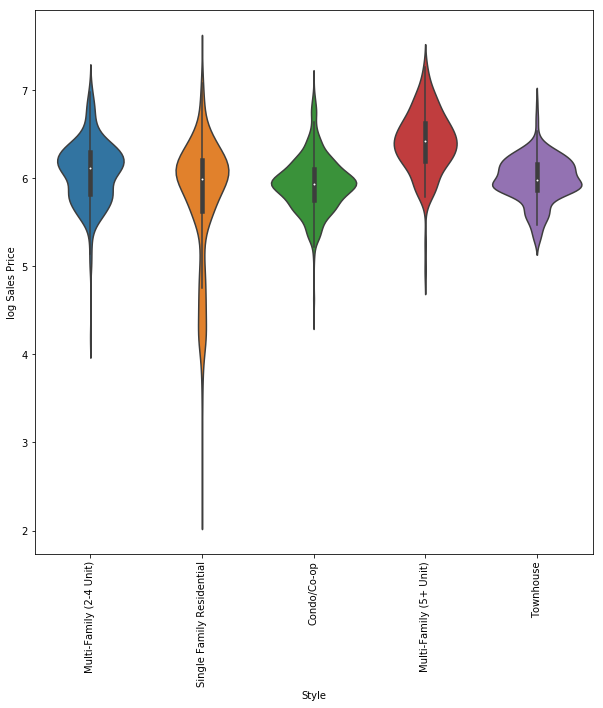

In [716]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.violinplot(x="Style", y="log Sales Price", data=df, jitter=True)
plt.xticks(rotation='vertical');

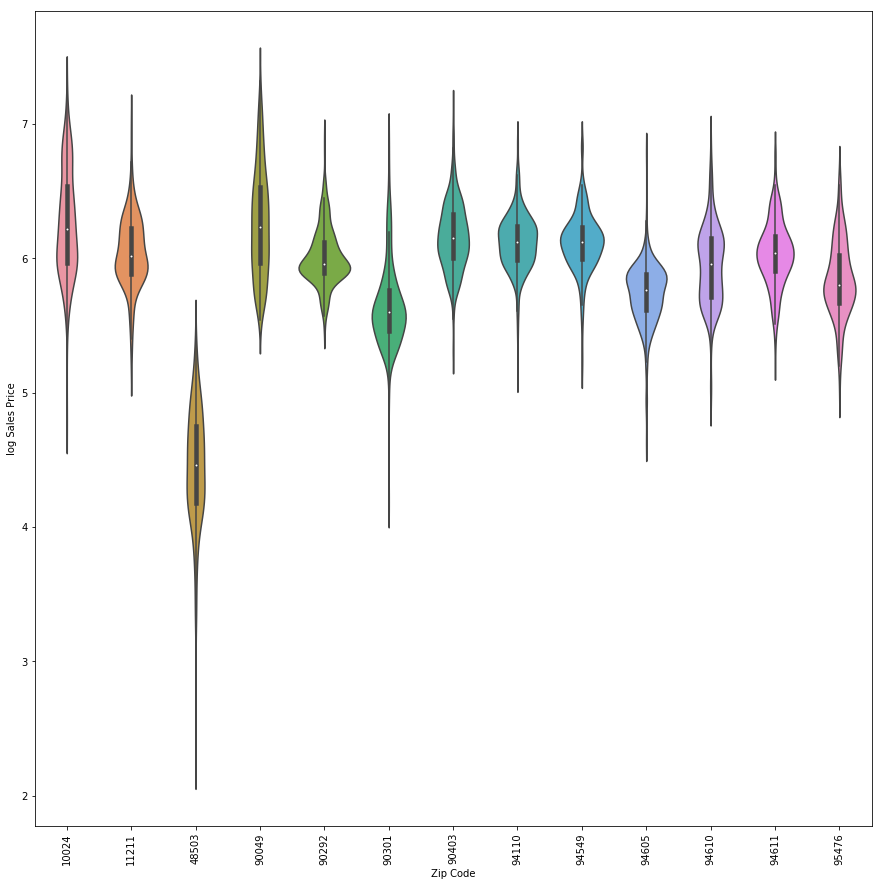

In [715]:
fig, ax = plt.subplots(figsize=(15,15))
seaborn.violinplot(x="Zip Code", y="log Sales Price", data=df, jitter=True)
plt.xticks(rotation='vertical');

,Baths,Beds,County,Last Sold,Sales Price,Stories,Style,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Zip Code,rURL,Lot Size Sq. Ft.
3326,nan,nan,Kings County,2018-03-14,43000000.0,6.0,Multi-Family (5+ Unit),74572.0,nan,2012.0,1960.0,11211,/NY/Brooklyn/442-Grand-St-11211/home/52054195,23086.8
3939,nan,nan,New York County,2016-11-07,172500000.0,17.0,Multi-Family (5+ Unit),141498.0,nan,1927.0,1993.0,10024,/NY/New-York/21-W-86th-St-10024/home/45272365,11325.6


In [664]:
df['Zip Code'].nunique()
df['Zip Code'].value_counts()

94611    359
90049    350
90403    350
94549    348
90301    346
90292    346
10024    344
94110    340
48503    339
11211    337
94605    337
94610    333
95476    303
Name: Zip Code, dtype: int64

In [ ]:
df.